In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from mnist import MNIST

/home/azfar305/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.test.is_gpu_available()

True

In [3]:
%reload_ext autoreload 
%matplotlib inline
%autoreload 2
from utilities import *

# Default figure size
plt.rcParams['figure.figsize'] = (7,5)

In [4]:
PATH = './data/fashion/'
data = MNIST(PATH)
data.gz = True
images,labels = data.load_training()

In [5]:
X_train = np.array(images).T
Y_train = np.array(labels)

In [6]:
classes = np.unique(Y_train)
C = classes.size; classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
description = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',
               4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',
               8:'Bag',9:'Ankle boot'}
description

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
pos = []
for val in classes:
    pos.append(np.where(Y_train == val)[0][0])

In [9]:
def plot_data(X,Y,description,num = 30,pos = None):
    
    if pos is None:
        pos = np.random.choice(Y.size,num,replace=False)
        width = 6
        height = math.ceil(num/width)
        fig = plt.figure(figsize=(width*1.8,height*1.8))
        for i in range(num):
            fig.add_subplot(height,width,i+1)
            img = X[:,pos[i]].reshape(28,28)
            plt.imshow(img,cmap='gray')
            if description is not None:
                plt.title(description[Y[pos[i]]])
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.6)
        plt.show()
        
    else:
        if len(pos) > num:
            pos = np.random.choice(pos,num)
        width = min(math.ceil(len(pos)/2),6)
        height = math.ceil(len(pos)/width)
        fig = plt.figure(figsize=(width*1.8,height*1.8))
        for i,val in enumerate(pos):
            fig.add_subplot(height,width,i+1)
            img = X[:,val].reshape(28,28)
            plt.imshow(img,cmap='gray')
            if description is not None:
                plt.title(description[Y[val]])
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.6)
        plt.show()
        

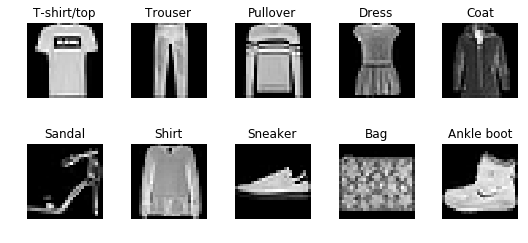

In [10]:
plot_data(X_train,Y_train,description,pos = pos)

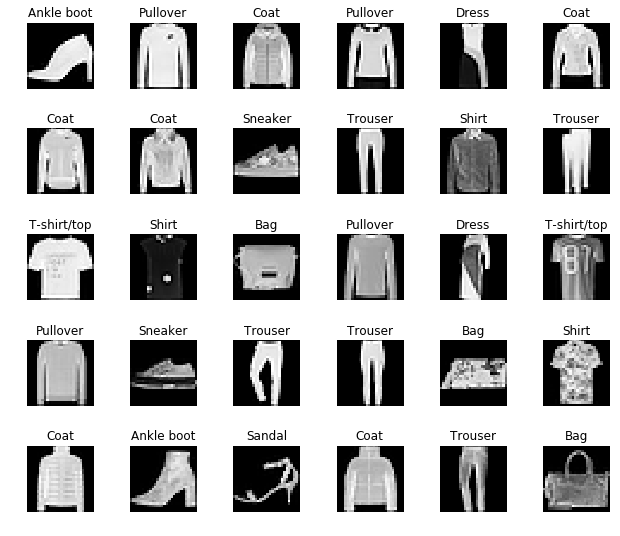

In [11]:
plot_data(X_train,Y_train,description)

Keys:  [0, 6, 2, 4]


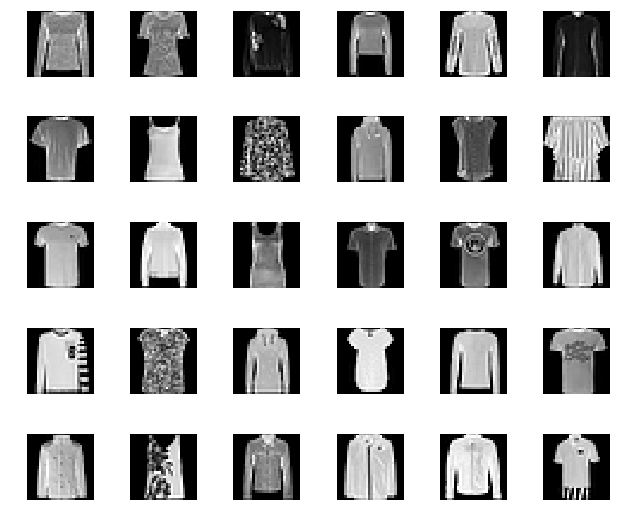

In [12]:
# Impossible to distinguish between T-shirt,Shirt,Pullover,Coat
indices = []
indices.append(list(description.values()).index('T-shirt/top'))
indices.append(list(description.values()).index('Shirt'))
indices.append(list(description.values()).index('Pullover'))
indices.append(list(description.values()).index('Coat'))
print('Keys: ',indices)
val = np.where(np.isin(Y_train,indices) == True)[0]
plot_data(X_train,Y_train,description=None,num=30,pos=val)

In [13]:
flip_X = horizontal_flip(X_train)

In [14]:
flip_X.shape

(784, 60000)

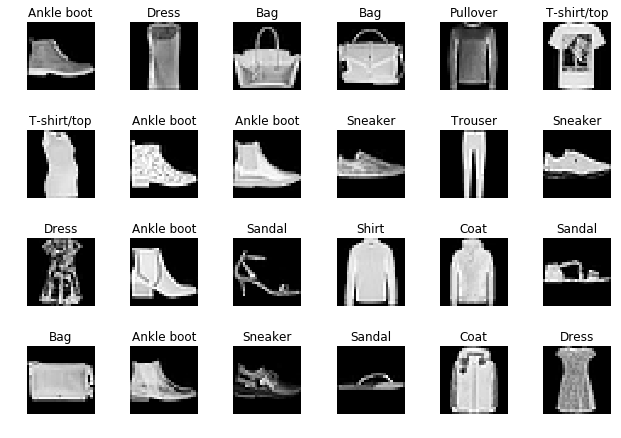

In [15]:
plot_data(flip_X,Y_train,description,num=24)

In [16]:
X_train = np.c_[X_train,flip_X]

X_train.shape

(784, 120000)

In [17]:
Y_train = np.append(Y_train,Y_train)

Y_train.shape

(120000,)

In [18]:
X_train = X_train/255

Yhot_train = one_hot_matrix(Y_train,C)

In [19]:
X_train.shape,Yhot_train.shape

((784, 120000), (10, 120000))

In [20]:
# Loading test set
# Performing the same preprocessing on the test set 
images,labels = data.load_testing()
X_test = np.array(images).T/255
Y_test = np.array(labels)

In [21]:
Yhot_test = one_hot_matrix(Y_test,C)

In [22]:
X_test.shape,Y_test.shape

((784, 10000), (10000,))

In [23]:
# Getting rid of unnecessary stuff
del(flip_X);del(images);del(labels)

In [24]:
# Sanity checking params_initialization
tf.reset_default_graph()
layers = [X_train.shape[0],25,12,C]
params = params_initialization(layers,0.0)
print("W1 = " + str(params["W1"]))
print("b1 = " + str(params["b1"]))
print("W2 = " + str(params["W2"]))
print("b2 = " + str(params["b2"]))
print("W3 = " + str(params["W3"]))
print("b3 = " + str(params["b3"]))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
W1 = <tf.Variable 'W1:0' shape=(25, 784) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(10, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(10, 1) dtype=float32_ref>


In [25]:
# Sanity checking forward propagation
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=(X_train.shape),name='X')
with tf.Session() as sess:
    params = params_initialization(layers,0.0)
    ZL = forward_propagation(X,params)
    print ("ZL = "+str(ZL))    

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
ZL = Tensor("add_2:0", shape=(10, 120000), dtype=float32)


In [26]:
def create_datset(Xall,Yall,batch_size,num_epocs):
    ds = tf.data.Dataset.from_tensor_slices((Xall,Yall))
    ds = ds.shuffle(buffer_size=tf.shape(Xall,out_type=tf.int64)[0])
    ds = ds.batch(batch_size=batch_size).repeat(num_epocs)
    return ds.make_initializable_iterator()

In [27]:
def lr_finder(X_train,Y_train,layer_dims,batch_size=256
              ,num_epocs=1,start = 1e-6,scale=1.03):
    
    ops.reset_default_graph()
    hist_cost = []
    hist_alpha = []
    
    assert(X_train.shape[1] == Y_train.shape[1])
    Xall = tf.placeholder(tf.float32,shape=X_train.T.shape,name='X_train')
    Yall = tf.placeholder(tf.float32,shape=Y_train.T.shape,name='Yhot_train')
    
    iterator = create_datset(Xall,Yall,batch_size,num_epocs)
    X,Y = iterator.get_next()
    X=tf.transpose(X); Y=tf.transpose(Y)
    params = params_initialization(layer_dims,lamb=0.0)
    
    ZL = forward_propagation(X,params)
    cost = costFunction(ZL,Y,reg_term=0)
   
    step = tf.Variable(0,trainable=False)
    alpha = lr_steps(start,scale,step)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost,global_step=step)
    init = tf.global_variables_initializer()
    smallest = np.inf
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iterator.initializer,feed_dict={Xall:X_train.T,
                                                Yall:Y_train.T})
        while True:
            try:
                _,batch_cost,alp,bats = sess.run([optimizer,cost,alpha,step])
                if batch_cost > 5*smallest:
                    break
                hist_cost.append(batch_cost)
                hist_alpha.append(alp)
                smallest = min(smallest,batch_cost)
            except tf.errors.OutOfRangeError:
                break

    #print('Number of Actual Batches: ',bats)
    #print("Minimum: ", smallest)
    return hist_alpha,hist_cost
            

In [28]:
layer_dims = [X_train.shape[0],60,50,25,C]


In [29]:
%%time
alpha,cost = lr_finder(X_train,Yhot_train,layer_dims,num_epocs=2)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
CPU times: user 3.49 s, sys: 515 ms, total: 4.01 s
Wall time: 4.24 s


In [30]:
len(cost),len(alpha)

(429, 429)

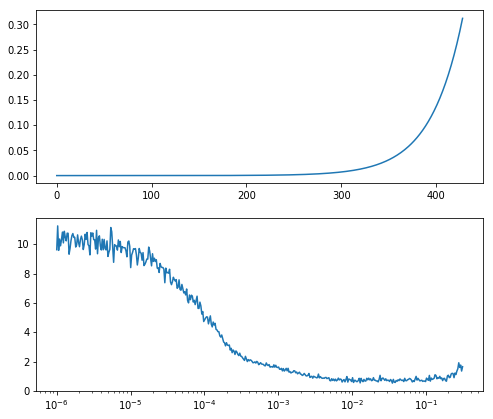

In [31]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.plot(alpha)
plt.subplot(2,1,2)
plt.semilogx(alpha,cost)

In [32]:
def predictClass(X,params):
    ZL = forward_propagation(tf.transpose(X),params)
    A = tf.nn.softmax(ZL,axis=0)
    return tf.argmax(A,axis=0)

In [33]:
def model(X_train,Y_train,X_test,layer_dims,alpha_lr =1e-4 ,lamb=0.0,
          batch_size = 256,num_epochs = 175):
    
    ops.reset_default_graph()
    hist_cost = []
    epoch_cost = []
    hist_alpha = []
    
    assert(X_train.shape[1] == Y_train.shape[1])
    Xall = tf.placeholder(tf.float32,shape=(None,X_train.shape[0]),name='X')
    Yall = tf.placeholder(tf.float32,shape=Y_train.T.shape,name='Yhot_train')
    
    iterator = create_datset(Xall,Yall,batch_size,num_epochs)
    X,Y = iterator.get_next()
    X=tf.transpose(X); Y=tf.transpose(Y)
    
    params = params_initialization(layer_dims,lamb)
    regularizer = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_term = tf.reduce_sum(regularizer)
    
    ZL = forward_propagation(X,params)
    cost = costFunction(ZL,Y,reg_term)
    num_batches = math.ceil(X_train.shape[1]/batch_size)

    
    step = tf.Variable(0,trainable=False)
    lr = tf.train.cosine_decay_restarts(alpha_lr,global_step=step, first_decay_steps=65*num_batches,
                                              t_mul=2,m_mul=1,alpha=0.01)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost,global_step=step)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iterator.initializer,feed_dict={Xall:X_train.T,
                                                Yall:Y_train.T})
        while True:
            try:
                _,batch_cost,alp,bats = sess.run([optimizer,cost,lr,step])
                hist_cost.append(batch_cost)
                hist_alpha.append(alp)
                if bats % (25*num_batches) == 0:
                    print("Completed {} epochs".format(int(bats/(num_batches))))
                    
            except tf.errors.OutOfRangeError:
                break
        
        for i in range(num_epochs):
            temp = hist_cost[i*num_batches:(i+1)*num_batches]
            epoch_cost.append(sum(temp)/num_batches)
            
        train_preds = predictClass(Xall,params)
        train_preds = sess.run(train_preds,feed_dict={Xall:X_train.T})
        
        test_preds = predictClass(Xall,params)
        test_preds = sess.run(test_preds,feed_dict={Xall:X_test.T})
        parameters = sess.run(params)
        
    return train_preds,test_preds,parameters,epoch_cost,hist_alpha
    
    

In [34]:
def predictClassV2(X,params):
    ZL = forward_propagation(X,params)
    A = tf.nn.softmax(ZL,axis=0)
    return tf.argmax(A,axis=0)

In [35]:
def modelV2(X_train,Y_train,X_test,Y_test,layer_dims,alpha_lr =1e-4 ,lamb=0.0,
          batch_size = 256,num_epochs = 175):
    
    ops.reset_default_graph()
    hist_cost = []
    epoch_cost = []
    hist_alpha = []
    
    assert(X_train.shape[1] == Y_train.shape[1])
    Xall = tf.placeholder(tf.float32,shape=(None,X_train.shape[0]),name='X')
    Yall = tf.placeholder(tf.float32,shape=Y_train.T.shape,name='Yhot_train')
    
    iterator = create_datset(Xall,Yall,batch_size,num_epochs)
    X,Y = iterator.get_next()
    X=tf.transpose(X); Y=tf.transpose(Y)
    
    params = params_initialization(layer_dims,lamb)
    
    
    ZL = forward_propagation(X,params)
    cost = costFunction(ZL,Y,reg_term=0)
    num_batches = math.ceil(X_train.shape[1]/batch_size)

    ##### Test Stuff
    XT = tf.placeholder(tf.float32,shape=X_test.shape,name='XTest')
    YT = tf.placeholder(tf.float32,shape=Y_test.shape,name='YTest')
    Z_test = forward_propagation(XT,params)
    cost_test = costFunction(Z_test,YT,reg_term=0)
    #########
    step = tf.Variable(0,trainable=False)
    #lr = tf.train.cosine_decay_restarts(alpha_lr,global_step=step, first_decay_steps=65*num_batches,
                                              #t_mul=2,m_mul=1,alpha=0.01)
    lr = alpha_lr
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost,global_step=step)
    init = tf.global_variables_initializer()
    num=5
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iterator.initializer,feed_dict={Xall:X_train.T,
                                                Yall:Y_train.T})
        while True:
            try:
                #_,batch_cost,alp,bats = sess.run([optimizer,cost,lr,step])
                _,batch_cost,bats = sess.run([optimizer,cost,step])
                hist_cost.append(batch_cost)
                #hist_alpha.append(alp)
                if bats % (num*num_batches) == 0:
                    train_cost = sum(hist_cost[-num_batches:])/(num_batches)
                    preds = predictClassV2(XT,params)
                    acc = tf.reduce_mean(tf.cast(tf.math.equal(preds,tf.argmax(YT,axis=0)),tf.float32))
                    test_cost,accur = sess.run([cost_test,acc],feed_dict={XT:X_test,YT:Y_test})
                    
                   
                    print('''Epoch: {},
                    Train Cost = {:.2},
                    Test Cost = {:.2}
                    Test Accuracy = {}'''.format(int(bats/(num_batches)),train_cost,test_cost,accur))
                    
                    
            except tf.errors.OutOfRangeError:
                break
        
        for i in range(num_epochs):
            temp = hist_cost[i*num_batches:(i+1)*num_batches]
            epoch_cost.append(sum(temp)/num_batches)
            
        train_preds = predictClass(Xall,params)
        train_preds = sess.run(train_preds,feed_dict={Xall:X_train.T})
        
        test_preds = predictClass(Xall,params)
        test_preds = sess.run(test_preds,feed_dict={Xall:X_test.T})
        parameters = sess.run(params)
        
    #return train_preds,test_preds,parameters,epoch_cost,hist_alpha
    return train_preds,test_preds,parameters,epoch_cost
    
    

In [ ]:
layer_dims = [X_train.shape[0],60,50,25,C]
train_preds,test_preds,params,cost = modelV2(X_train,Yhot_train,X_test,Yhot_test,
                                layer_dims,num_epochs=50)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [88]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 92.63
Test Acurracy: 87.87


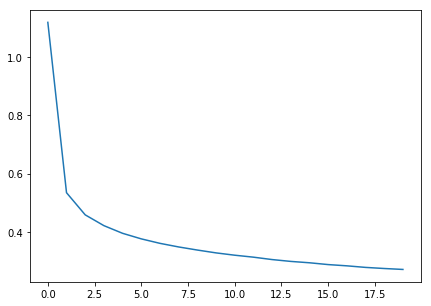

In [68]:
plt.plot(cost)

In [92]:
cost[9]

0.33036834169933793

In [34]:
np.argmax(Yhot_test,axis=0).shape

(10000,)

In [36]:
Y_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)